In [54]:
%matplotlib notebook
import time

import numpy as np
import matplotlib.pyplot as pl

import tacoma as tc
from tacoma.drawing import draw_edges
from tacoma.analysis import temporal_network_group_analysis
from tacoma.model_conversions import estimate_flockwork_P_args

# Load original network

In [55]:
socio = tc.load_sociopatterns_hypertext_2009()
socio_result = tc.measure_group_sizes_and_durations(socio)

# Simulate Flockworks accordingly

In [56]:
fwP_params = estimate_flockwork_P_args(socio,N_time_steps=100,aggregated_network=socio_result.aggregated_network)
fwP = tc.flockwork_P_varying_rates_neighbor_affinity(**fwP_params)
fwP_binned = tc.bin(fwP,dt=20)

# Set disease parameters

In [57]:
R0 = 2.0                  # number of secondary infections
rho = 1.0 / (24*3600.)    # recovery rate in 1/s
dt = 600                  # bin for sampling
t_simulation = 4*fwP.tmax # simulation_time
t_sample = np.arange(int(t_simulation / dt)+1,dtype=float) * dt 
N = socio.N

N_meas = 30 # measurements per network

# Simulate

<IPython.core.display.Javascript object>


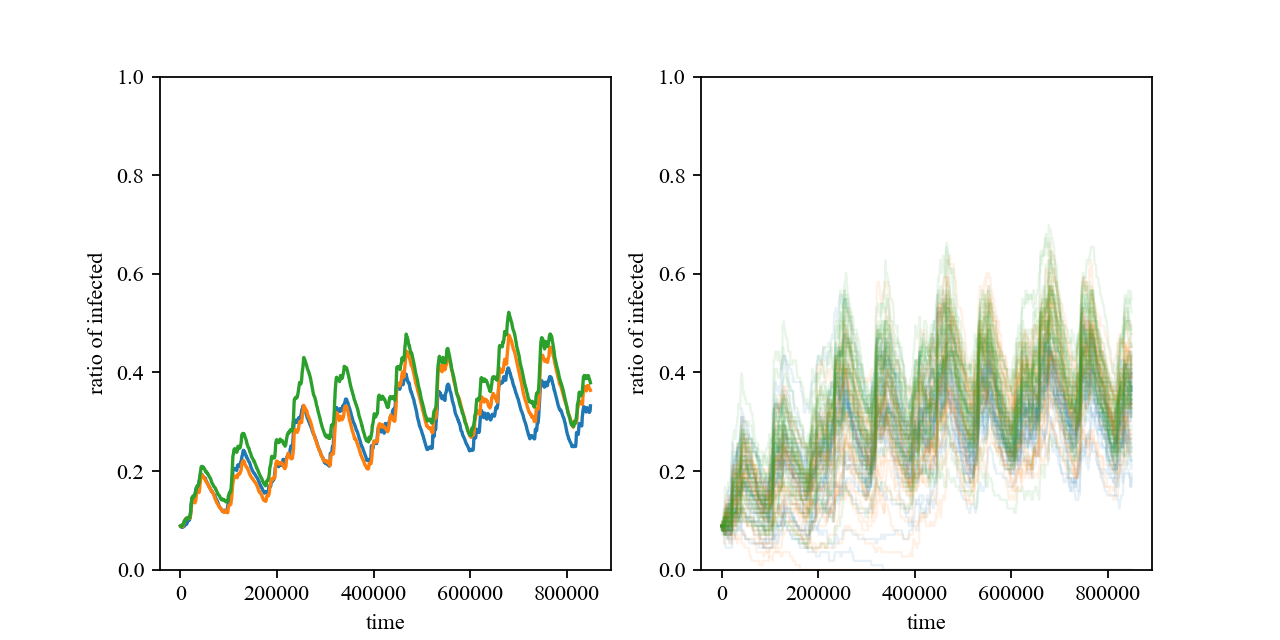

In [59]:
fig, ax = pl.subplots(1,2,figsize=(8,4))

for i_tn, tn in enumerate([socio, fwP, fwP_binned]):

    # compute the mean degree over the time
    t, k = np.array(tc.mean_degree(tn))
    mean_k = tc.time_average(t, k)    

    # compute the infection rate
    eta = R0 * rho / mean_k
    
    # prepare the measured infected curve
    i_sample = np.zeros_like(t_sample)
    
    # count the samples where i(t_simulation) > 0
    succecssful_samples = 0

    for meas in range(N_meas):

        # prepare SIS object
        sis = tc.SIS(N, t_simulation, eta, rho, number_of_initially_infected = 10)

        # simulate SIS
        tc.gillespie_SIS(tn, sis)

        # get observables
        t = np.array(sis.time)
        i = np.array(sis.I,dtype=float) / N

        # sample from the observables
        this_sample = tc.sample_a_function(t,i,t_sample)
        
        # only count this if i(t_simulation) > 0
        if this_sample[-1] > 0.0:
            succecssful_samples += 1
            i_sample += this_sample
        
        # plot this single simulation        
        ax[1].plot(t_sample,this_sample,c=tc.color_sequence[i_tn],alpha=0.1,lw=1)

    # plot the mean of this simulation
    ax[0].plot(t_sample,i_sample/succecssful_samples)
    
ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[0].set_xlabel('time')
ax[0].set_ylabel('ratio of infected')
ax[1].set_xlabel('time')
ax[1].set_ylabel('ratio of infected')

In [39]:
fwP.tmax/100

2123.6